In [1]:
from shapely.geometry import Point,mapping, LineString, Polygon
import numpy as np
import rasterio
from rasterio import plot, mask
from rtree import index
import networkx as nx
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
OS_National_Grids = gpd.read_file(os.path.join('OS-British-National-Grids-main','OS-British-National-Grids-main','os_bng_grids.gpkg'),layer='1km_grid')
study_area_shapely = OS_National_Grids[OS_National_Grids['tile_name'] == "SX7577"].geometry.cascaded_union

Haytor_map = rasterio.open(
        os.path.join('OS Explorer Maps', 'Download_SX77-Haytor_2033809', 'raster-25k_4596071', 'sx', 'sx77.tif'))
elevation = rasterio.open(os.path.join('OS Elevation','Download_Haytor_Elevation_2035988','terrain-5-dtm_4600215','sx','SX77NE.asc'))

study_area = mapping(study_area_shapely)
elevation_mask, transform_index = mask.mask(elevation,[study_area], filled=False, crop=False)


network_links = gpd.read_file(os.path.join('Study_area','network_links_2.geojson'))
network_nodes = gpd.read_file(os.path.join('Study_area','network_nodes_2.geojson'))


## Normalising values

In [4]:
network_links['angle_normalised'] = network_links['angle'].div(network_links['angle'].sum())
network_links['total_time_normalised'] = network_links['total_time']\
    .div(network_links['total_time'].sum())
network_links['DPN_normalised'] = network_links['DPN'].div(network_links['DPN'].sum())
network_links['surface_cost_normalised'] = network_links['surface_cost'].div(network_links['surface_cost'].sum())



## Set Start and End point

In [ ]:
start_point = 6

end_point = 1633

## Add weights

In [12]:
easy = [0.2,0,0.5,0.3]
intermediate = [0.1,0.2,0.3,0.4]
expert = [0,0.8,0.1,0.1]

### Easy

In [13]:
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    angle = (row.angle_normalised * easy[0])*100000
    travel_time = (row.total_time_normalised * easy[1])*100000
    dpn = (row.DPN_normalised * easy[2])*100000
    surface_cost = (row.surface_cost_normalised * easy[3])*100000
    # Weighted Sum method
    wsm = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=start_point, target=end_point, weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_easy_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

## Intermediate

In [7]:
weights = [0.05,0.9,0.05]
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    angle = (row.angle_normalised * intermediate[0])*100000
    travel_time = (row.total_time_normalised * intermediate[1])*100000
    dpn = (row.DPN_normalised * intermediate[2])*100000
    surface_cost = (row.surface_cost_normalised * intermediate[3])*100000
    # Weighted Sum method
    wsm = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=start_point, target=end_point, weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_intermediate_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

## expert

In [8]:
weights = [0.05,0.05,0.09]
graph = nx.DiGraph()
for index,row in network_links.iterrows():

    angle = (row.angle_normalised * expert[0])*100000
    travel_time = (row.total_time_normalised * expert[1])*100000
    dpn = (row.DPN_normalised * expert[2])*100000
    surface_cost = (row.surface_cost_normalised * expert[3])*100000
    # Weighted Sum method
    wsm = angle + travel_time + dpn + surface_cost

    graph.add_edge(row['startnode'], row['endnode'], fid=row['fid'],
               length=row.length,
               weighted_sum=wsm)

# get the shortest path with time weight
weighted_path = nx.dijkstra_path(graph, source=start_point, target=end_point, weight='weighted_sum')

geom = []
links = []
first_node = weighted_path[0]
for node in weighted_path[1:]:
    link_fid = graph.edges[first_node, node]['fid']
    links.append(link_fid)
    row = network_links.loc[network_links['fid'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

weighted_path_expert_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})

C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:8: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\raffy\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:34: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.


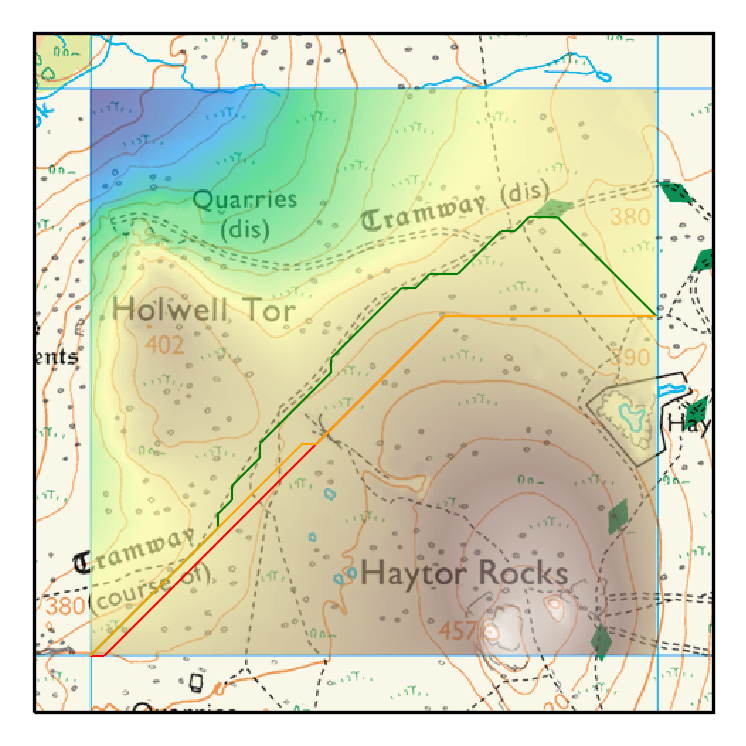

In [14]:
back_array = Haytor_map.read(1)
palette = np.array([value for key, value in Haytor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = Haytor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

fig = plt.figure(figsize=(3, 3), dpi=300)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())

# display background map
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)

# display elevation
rasterio.plot.show(elevation_mask, alpha=0.6, transform=transform_index, ax=ax, zorder=1,
                           cmap='terrain')

# displaying nodes
# network_nodes.plot(ax=ax,zorder = 3,markersize=0.2)
#
# displaying links
# network_links.plot(ax=ax,zorder = 2,edgecolor='blue', linewidth=0.2)

# display path
weighted_path_easy_gpd.plot(ax=ax,zorder = 5,edgecolor='green', linewidth=0.5,label = 'easy')
weighted_path_intermediate_gpd.plot(ax=ax,zorder = 6,edgecolor='orange', linewidth=0.5,label = 'intermediate')
weighted_path_expert_gpd.plot(ax=ax,zorder = 5,edgecolor='red', linewidth=0.5,label = 'expert')


#set the extent to the study area
#study_area_gpd.plot(ax=ax,zorder = 2)
display_extent = ((study_area_shapely.bounds[0]- 100, study_area_shapely.bounds[2]+ 100,
                       study_area_shapely.bounds[1]- 100, study_area_shapely.bounds[3]+ 100))

ax.set_extent(display_extent, crs=crs.OSGB())
plt.show()